In [1]:
import nltk
import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.svm import LinearSVC
from gensim.models import KeyedVectors
from tqdm import tqdm

In [2]:
sentiment_data = pd.read_csv("/home/igel/Downloads/train.csv")

In [4]:
all_texts = sentiment_data['message']

In [7]:
all_texts_joint = ' '.join(all_texts)

In [10]:
all_texts_joint[0]

'<'

In [8]:
tokens =  nltk.RegexpTokenizer('\w+').tokenize(all_texts_joint)

In [9]:
assert isinstance(tokens, list)
assert isinstance(tokens[0], str)
print('done')

done


In [11]:
tokens[0]

'USER_0'

##### Build a dictionary {token: token_id} of 50000 most frequent tokens.

In [16]:
vocabulary_size = 50000
import collections
def build_vocabulary(tokens, max_size=20000):
    """
    Builds a vocabulary of at most max_size words from the supplied list of lists of tokens.
    If a word embedding model is provided, adds only the words present in the model vocabulary.
    """
    # your code goes here
    vocabulary = {}
    reserved_symbols = ["NULL", "UNKN"]
    
    counter = collections.Counter(tokens)
    
    freq_toks = counter.most_common(max_size-len(reserved_symbols))

    voc_words = [k[0] for k in freq_toks]

    for i, reserved in enumerate(reserved_symbols):
        vocabulary[reserved] = i

    for i, k in enumerate(voc_words):
        vocabulary[k] = i+len(reserved_symbols)

    return vocabulary

In [17]:
dictionary = build_vocabulary(tokens, vocabulary_size)

In [18]:
reverse_dictionary = {val: keey for keey, val in dictionary.items()}

In [19]:
def encode(tokens, token_to_id):
    return [token_to_id.get(t, token_to_id['UNKN']) for t in tokens]

In [20]:
### pickle

In [21]:
data = encode(tokens, dictionary)

In [28]:
dictionary['one']
reverse_dictionary[56]

'one'

In [31]:
data_index = 0
import random
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    # Initilzing a buffer to sample from
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    # Moving over the the corpus to the next buffer while we get a whole batch
    for i in range(batch_size // num_skips):
        target = skip_window  # set target somewehre, then find the right ones
        targets_to_avoid = [ skip_window ]  #don't use the center word as a target
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])
# Let's test how this works
for num_skips, skip_window in [(2, 1)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['USER_0', 'Unfortunately', 'it', 's', 'the', 'world', 'They', 'actually']

with num_skips = 2 and skip_window = 1:
    batch: ['Unfortunately', 'Unfortunately', 'it', 'it', 's', 's', 'the', 'the']
    labels: ['it', 'USER_0', 's', 'Unfortunately', 'it', 'the', 'world', 's']


In [36]:
import tensorflow as tf
import math
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
    # Variables.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
    # Model.
    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                                   labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

    # Optimizer.
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    # This is because the embeddings are defined as a variable quantity and the
    # optimizer's `minimize` method will by default modify all variable quantities 
    # that contribute to the tensor it is passed.
    # See docs on `tf.train.Optimizer.minimize()` for more details.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [41]:
len(data)  / (batch_size/ num_skips)
num_steps = int(len(data)  / (batch_size/ num_skips))
num_steps

270565

Initialized
Average loss at step 0: 8.333422


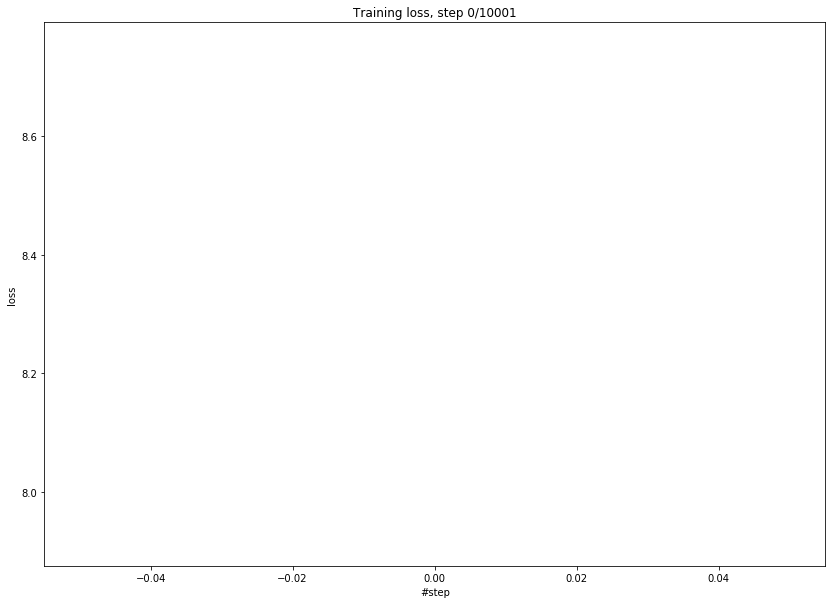

Nearest to I: Rashard, Raid, ermm, DRY, Presets, WEN, Patty, Vineyard,
Nearest to really: suspect, 3500, Jailbreak, babyyy, cuter, graduating, sprint, excedrin,
Nearest to out: mcflurry, Anonymous, Donï, heathers, Olivia, Yummmm, acknowledging, shittttt,
Nearest to an: erasing, Supreme, compound, ia, tripple, startd, Next, particular,
Nearest to work: risotto, NASA, downloadin, upstate, ventures, proofread, opps, worrk,
Nearest to love: catchy, gradually, RAINY, Tangerine, ng, 63, Cept, splinter,
Nearest to have: counterpart, shipping, courtney, Literature, TMNT, het, Ð¾, rlly,
Nearest to 2: PCI, moved, Spiders, revisin, Isaiah, pao, Goldie, ÑƒÑ,
Nearest to if: taxed, manufacturing, Rock, predictions, PLEASEEEEEEEE, 99p, OMGGGG, harper,
Nearest to me: pickups, Minds, independent, decluttering, El, DON, concerts, fellow,
Nearest to from: network, rythm, Rough, vhs, code, recipe, Record, Sera,
Nearest to URL_0: MOVING, HAM, Kmart, mugging, Twidroid, GK, hectic, inggit,
Nearest to its: re

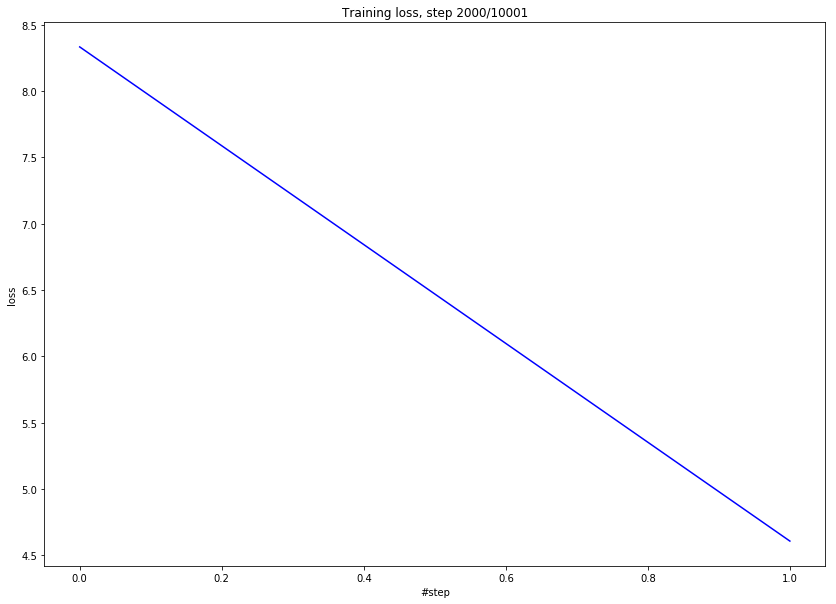

Nearest to I: i, it, you, USER_0, lol, we, Im, he,
Nearest to really: suspect, babyyy, excedrin, shooot, Coronas, Fuuuck, lugging, he,
Nearest to out: heathers, Anonymous, absinthe, mcflurry, twitterland, welly, Do, Yummmm,
Nearest to an: circa, ia, Dragon, NAMED, compound, Supreme, n0, Matthew,
Nearest to work: risotto, NASA, attractions, Ahem, stormin, sg, killer, infections,
Nearest to love: gradually, catchy, 44am, pritty, splinter, RAINY, lucid, SHS,
Nearest to have: personally, altough, farah, Trader, counterpart, determines, fades, help,
Nearest to 2: ÑƒÑ, revisin, moved, PCI, Aloe, HTTP, Blackburn, byeee,
Nearest to if: PLEASEEEEEEEE, extract, Rowling, taxed, Owner, palace, predictions, manufacturing,
Nearest to me: tuesday, pickups, decluttering, you, butler, Rooting, my, States,
Nearest to from: vhs, nooooooooooo, network, eyelids, rythm, aspirations, Record, studyin,
Nearest to URL_0: MOVING, Floral, mugging, week, watchers, tov, Twidroid, togetherness,
Nearest to its: douch

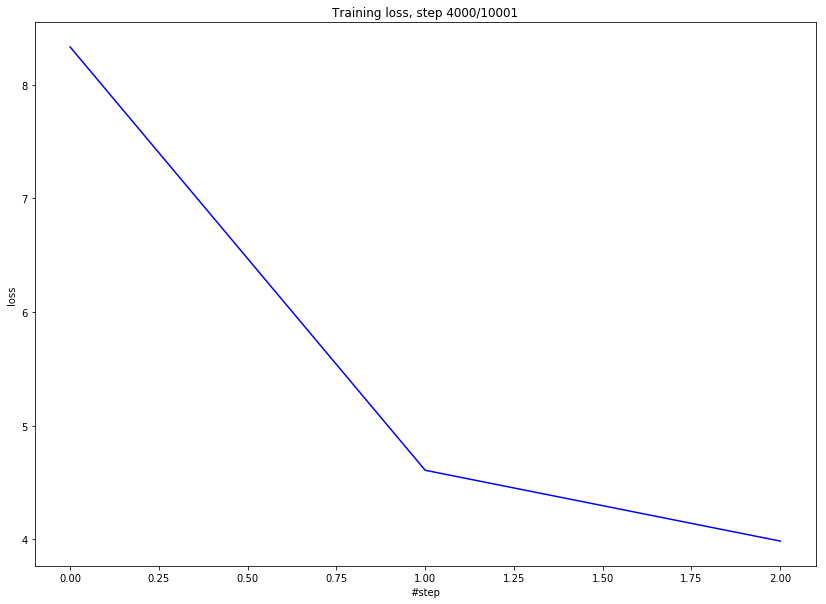

Nearest to I: i, you, we, they, HM, u, overseas, tutorials,
Nearest to really: suspect, Fuuuck, so, babyyy, actually, Coronas, ceral, he,
Nearest to out: mcflurry, Anonymous, twitterland, welly, Do, heathers, back, absinthe,
Nearest to an: circa, Dragon, NAMED, Supreme, a, n0, Next, Matthew,
Nearest to work: risotto, NASA, Ahem, infections, Survived, snows, joints, sg,
Nearest to love: catchy, gradually, 44am, RAINY, splinter, Shades, SHS, pritty,
Nearest to have: personally, altough, need, had, ve, get, Trader, be,
Nearest to 2: to, Aloe, HTTP, ÑƒÑ, moved, revisin, Blackburn, his,
Nearest to if: PLEASEEEEEEEE, extract, palace, Rowling, Owner, taxed, Barbeque, unpack,
Nearest to me: you, Rooting, Install, pickups, decluttering, illiterate, butler, tuesday,
Nearest to from: in, vhs, aspirations, at, nooooooooooo, to, calc, and,
Nearest to URL_0: UNKN, week, thanks, MOVING, today, watchers, Floral, later,
Nearest to its: lemongrass, is, im, Rewind, reloading, tuesdays, douches, NorCal,
N

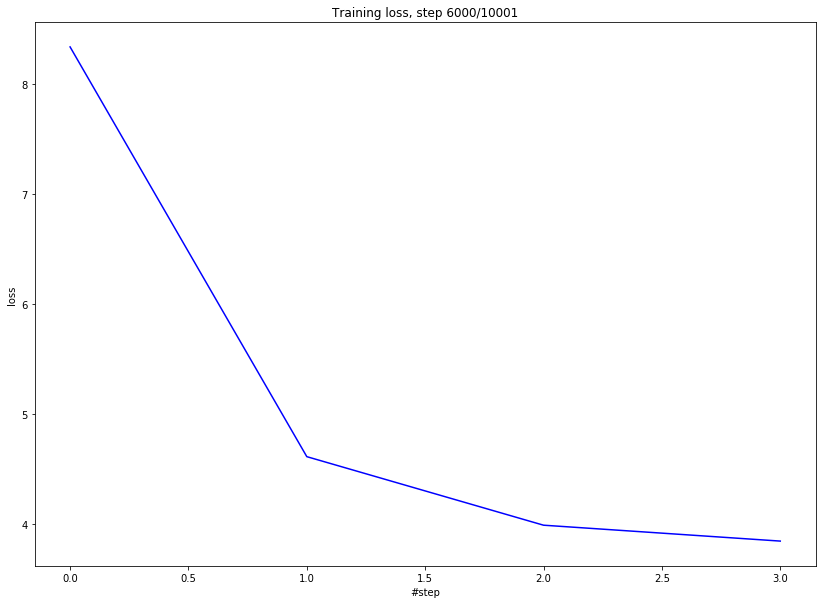

Nearest to I: i, we, they, HM, you, tutorials, You, he,
Nearest to really: suspect, so, Fuuuck, actually, Ani, shooot, Cactus, Shred,
Nearest to out: mcflurry, twitterland, heathers, Do, Anonymous, absinthe, back, runny,
Nearest to an: circa, Dragon, Supreme, Next, pounds, NAMED, Matthew, hercules,
Nearest to work: risotto, Survived, Ahem, NASA, snows, joints, doth, wtk,
Nearest to love: frens, RAINY, pritty, catchy, miss, Shades, gradually, 44am,
Nearest to have: ve, altough, had, need, personally, get, be, Sammy,
Nearest to 2: to, Blackburn, HTTP, moved, Aloe, revisin, ÑƒÑ, Isaiah,
Nearest to if: Rowling, palace, PLEASEEEEEEEE, Now, extract, Barbeque, Owner, Gimp,
Nearest to me: you, illiterate, her, pickups, us, Install, 3G, it,
Nearest to from: in, at, on, vhs, to, and, aspirations, hawthorne,
Nearest to URL_0: week, today, thanks, later, UNKN, lol, Jai, watchers,
Nearest to its: im, lemongrass, is, bricked, tuesdays, Rewind, douches, NorCal,
Nearest to there: it, mater, Jee, negat

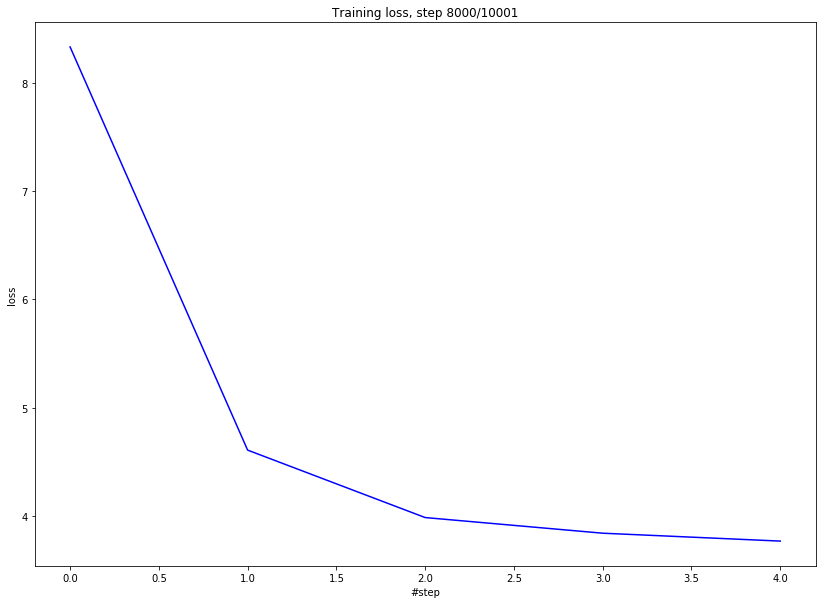

Nearest to I: i, we, they, You, you, HM, he, haha,
Nearest to really: so, suspect, Fuuuck, actually, Shred, Cactus, shooot, pagi,
Nearest to out: twitterland, mcflurry, up, heathers, Anonymous, welly, back, shittttt,
Nearest to an: circa, Supreme, Dragon, Next, pounds, NAMED, trippin, platforms,
Nearest to work: risotto, Survived, joints, school, home, applicants, snows, doth,
Nearest to love: miss, 200th, pritty, frens, SENDING, hate, do, 44am,
Nearest to have: ve, need, had, altough, get, personally, has, Thread,
Nearest to 2: to, HTTP, ÑƒÑ, Blackburn, moved, Aloe, Isaiah, revisin,
Nearest to if: palace, PLEASEEEEEEEE, Rowling, extract, Now, Gimp, notice, Barbeque,
Nearest to me: us, you, him, it, her, illiterate, pickups, tuesday,
Nearest to from: in, at, on, and, vhs, Plane, for, FriendFeed,
Nearest to URL_0: today, lol, later, thanks, nurses, watchers, UNKN, gloucester,
Nearest to its: im, lemongrass, is, Rewind, bricked, i, devotion, s,
Nearest to there: mater, it, EXAM, plans, n

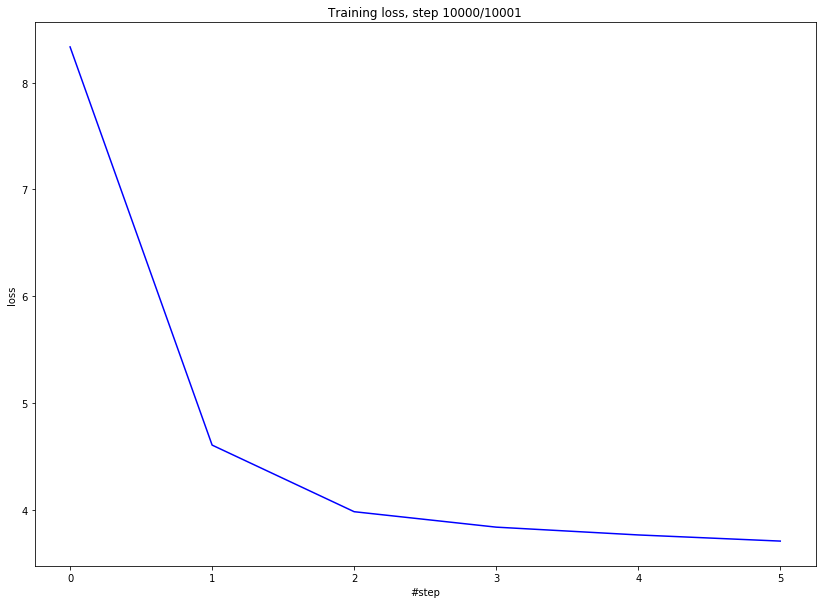

Nearest to I: i, we, they, you, You, HM, We, u,
Nearest to really: so, Fuuuck, actually, suspect, just, always, tap, consisting,
Nearest to out: twitterland, up, mcflurry, heathers, Thriller, back, geting, Laughing,
Nearest to an: Supreme, circa, Dragon, Next, pounds, Serious, trippin, platforms,
Nearest to work: Survived, school, risotto, joints, lunch, sleep, nothing, home,
Nearest to love: miss, hate, do, pritty, Tilt, 44am, 200th, know,
Nearest to have: ve, had, need, want, altough, get, be, has,
Nearest to 2: to, HTTP, Blackburn, ÑƒÑ, Isaiah, Soaked, revisin, burped,
Nearest to if: palace, Barbeque, Now, but, Rowling, extract, what, Gimp,
Nearest to me: us, him, it, u, her, illiterate, you, tuesday,
Nearest to from: in, at, and, with, for, on, FriendFeed, Plane,
Nearest to URL_0: today, lol, UNKN, thanks, unpack, watchers, masquerade, doesnï,
Nearest to its: im, is, s, i, lemongrass, bricked, Rum, devotion,
Nearest to there: it, plans, Jee, mater, iChat, depart, JEALOUS, Sanford,


In [49]:
num_steps = 10001
lh = []
%matplotlib inline
import matplotlib.pyplot as plt

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(
          batch_size, num_skips, skip_window)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            #display.clear_output(wait=True)
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            lh.append(average_loss)
            average_loss = 0

            plt.figure(figsize=(14, 10))

            plt.title("Training loss, step {}/{}".format(step, num_steps))
            plt.xlabel("#step")
            plt.ylabel("loss")
            plt.plot(lh, 'b')
            plt.show()

        if step % 2000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

In [52]:
import json

from sklearn.manifold import TSNE
dd = json.load(open('topical_words.json'))
colors = {'colors':'r', 'vegetables':'g', 'numbers':'b', 'professions': 'GoldenRod'}
wd = {}
for k in dd:
    for w in dd[k]:
        if w in dictionary:
            wd[w] = {'emb': final_embeddings[dictionary[w]], 'label': k, 'color': colors[k]}
            
M = np.array([wd[k]['emb'] for k in wd])
labels = [wd[k]['label'] for k in wd]
colors = [wd[k]['color'] for k in wd]

P = squareform(pdist(M, metric='cosine'))
tsne2 = TSNE(n_components=2, random_state=34, metric='precomputed', n_iter=9001)
Y = tsne2.fit_transform(P)

FileNotFoundError: [Errno 2] No such file or directory: 'topical_words.json'

## Exercise 3: word vectors meet bag of words

In this exercise you use your newly trained word vectors and a simple Bag of Words models to approach the sentiment analysis task

In [ ]:
# We will use a convinient wrapper for our word2vec model provided by gensim

In [ ]:
w2v_model = KeyedVectors.load_word2vec_format("./simple_cbow.w2v")

In [ ]:
# you can get the vector for a word in a simple way
w2v_model['word']

In [ ]:
# you can easily query the model for word most similar to a give word 
w2v_model.most_similar('funny')

### 3.1

In this exercise you learn how to encode sentences with word2vec using a bag of words approach

In [ ]:
# implement a tokenizer that you will use throughout the exercise
# I would recommend a regexp tokenizer for speed, but it's completely up to you
def my_tokenizer(text):
    return nltk.regexp_tokenize(text, '\w+')

In [ ]:
def bow_encoder(wmodel, tokenizer, text):
    """
    This function encodes text into a vector.
    
    First, it tokenizes input text using the provided tokenizer function.
    Then it uses the provided word2vec model to get the vectors corresponding to text's tokens.
    Finally, it computes an average of all token's vectors and returns it.
    
    If the function failed to find and encode any words, it should at least return a vector of zeros.
    """
    zero_vector = np.zeros(w2v_model.vector_size)
    # your code goes here
    return sent_vector

Now use your new encoder to encode both train_texts and test_texts into matrices.

The number of rows in a matrix should be equal to the number of texts encoded.

The number of columns should be equal to the word2vec space dimansionality (currently = 128)

Just write a little loop.

In [ ]:
train_encoded = 
test_encoded = 

In [ ]:
assert isinstance(train_encoded, np.ndarray)
assert isinstance(test_encoded, np.ndarray)

assert train_encoded.shape[0] == len(train_texts)
assert train_encoded.shape[1] == w2v_model.vector_size

assert test_encoded.shape[0] == len(test_texts)
assert test_encoded.shape[1] == w2v_model.vector_size
print('done')

In [ ]:
clf = LinearSVC()
clf.fit(train_encoded, train_labels)
preds = clf.predict(test_encoded)

print(classification_report(test_labels, preds))
print("AUC = {}".format(roc_auc_score(test_labels, preds)))

### Not too impressive!

### 3.2

In this exercise you attempt to improve your encoder by filtering out stop words.

In [ ]:
def bow_encoder_with_stopwords(wmodel, tokenizer, stopwords, text):
    """
    This function encodes text into a vector.
    
    First, it tokenizes input text using the provided tokenizer function.
    Then it removes any stopwords from the list of tokens.
    Then it uses the provided word2vec model to get the vectors corresponding to text's tokens.
    Finally, it computes an average of all token's vectors and returns it.
    
    If the function failed to find and encode any words, it should at least return a vector of zeros.
    """
    zero_vector = np.zeros(w2v_model.vector_size)
    # your code goes here
    return sent_vector

In [ ]:
stops = set(nltk.corpus.stopwords.words('english'))

In [ ]:
train_encoded = 
test_encoded = 

In [ ]:
clf = LinearSVC()
clf.fit(train_encoded, train_labels)
preds = clf.predict(test_encoded)

print(classification_report(test_labels, preds))
print("AUC = {}".format(roc_auc_score(test_labels, preds)))

## Looks like the BoW model is not too good for the job!

![architecture](pics/we_need_to_go_deeper.jpg)

## Introducing: Keras

Keras is a cool library built on top of the computational backend provided by Tensorflow. It provides a layer of abstraction between you and complicated tensor algebra, allowing for rapid prototyping of deep neural networks.

### 3.3: Data preparation

Before we start crunching word vectors with convolutional neural networks, we need to prepare our data.

In [ ]:
import keras

In [ ]:
# load the vocabulary we created earlier
voc, rvoc = pickle.load(open("./dict_rdict.pkl","rb"))

In [ ]:
# we are going to use the whole dataset this time around
texts = sentiment_data['message'].tolist()
labels = np.array(sentiment_data['sentiment'])

train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, random_state=21)

Recall the function that turns tokens into their ids

In [ ]:
# hint: you may want to use the function you've built during seminar 2
MAX_LEN = 32

def vectorize_tokens(sentence, tokenizer, token_to_id, max_len):
    """
    Preprocesses a sentence into list of tokens using the provided tokenizer
    Then converts it into a list of token ids using the supplied 'token_to_id' dictionary.
    Pads resulting list with NULL identifiers up to max_len length. 
    """
    # your code goes here
    # STEP 1: convert sentence to a list of tokens
    
    # STEP 2: replace tokens with their identifiers from the vocabulary
    # If the token is not present in the vocabulary, replace it with UNKN identifier

    # STEP 3: pad the sequence id's with NULL identifiers until so that it's length is equal to max_len

    return ids

Now apply the vectorization function to every sentence from train and test datasets. In the end you should end up with a matrix of shape [len(data), MAX_LEN].

Just write a little loop

In [ ]:
def vectorize_sentences(sentences, tokenizer, token_to_id, max_len):
    sentence_ids = []
    
    # your code goes here
        
    return np.array(sentence_ids)

In [ ]:
train_vectorized = vectorize_sentences(train_texts, my_tokenizer, voc, MAX_LEN)
test_vectorized = vectorize_sentences(test_texts, my_tokenizer, voc, MAX_LEN)

In [ ]:
assert isinstance(train_vectorized, np.ndarray)
assert isinstance(test_vectorized, np.ndarray)

assert train_vectorized.shape == (len(train_vectorized), MAX_LEN)
assert test_vectorized.shape == (len(test_vectorized), MAX_LEN)

print('done')

### 3.4 Building a deep NN

In [ ]:
embeddings_matrix = w2v_model.syn0

In [ ]:
# keras Input layer is basically the same thing as tf.placeholder
# it defines a node where the network will be expecting to recieve input data
input_layer = keras.layers.Input(shape=(MAX_LEN,))

In [ ]:
# keras Embedding layer is a container for dense vectors
# it recieves a list of token identifiers of shape [MAX_LEN] 
# and turns it into a matrix of shape [MAX_LEN, EMBEDDING_DIM]

embedding_layer = keras.layers.Embedding(embeddings_matrix.shape[0], embeddings_matrix.shape[1], 
                                         input_length=MAX_LEN, weights=[embeddings_matrix],
                                         trainable=False)(input_layer)
# notice how the input_layer is plugged into the embedding_layer

In [ ]:
# keras Convolutional layer implements a set of learnable filters
# that extract local patterns from input data
convolution_layer = keras.layers.Convolution1D(128, 3)(embedding_layer)

In [ ]:
# keras GlobalMaxPooling layer applies a max filter to the input feature representation
# only the strongest responses from the previous layer are kept, everything else is discarded
subsampling_layer = keras.layers.GlobalMaxPooling1D()(convolution_layer)

In [ ]:
# keras Linear layers apply a simple linear transformation to input data, 
# which is optionally followed by a non-linear activation function
# very useful for building Multi-Layer Perceptrons
linear_layer_1 = keras.layers.Dense(64, activation='relu')(subsampling_layer)
linear_layer_2 = keras.layers.Dense(1, activation='sigmoid')(linear_layer_1)

In [ ]:
# this compiles the computational graph we've just created, applies a loss function
# and pre-computes the gradients for back propagation

deep_model = keras.models.Model(inputs=[input_layer], outputs=[linear_layer_2])
deep_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
deep_model.summary()

In [ ]:
deep_model.fit(x=train_vectorized, y=train_labels, batch_size=64, epochs=3, 
               validation_data=[test_vectorized, test_labels])

In [ ]:
preds = deep_model.predict(test_vectorized)

In [ ]:
print("AUC = {}".format(roc_auc_score(test_labels, preds)))

In [ ]:
deep_model.save_weights("nn_weights.hdf5")

### Thats more like it! Keep in mind that we only trained a tiny model because of the limitations of CPU computing power. Using a deeper model with more trainable filters in the Convolution layer would likely result in even stronger predictive power. Stay tuned! 